# Exercise 6: ARMA and GARCH models

**_Group: Ducray, Razanajatovo_**

<br/>
<div style="text-align: justify">Please find below our study on Apple's daily price log returns. We aimed at fitting the optimal AR-GARCH model using both expanding and recursive windows to forecast the latter.</div>

<br/>
<div style="text-align: justify">The code breaks down in 4 main steps: data preparation, Box-Jenkins approach for ARMA and GARCH process', forecasting analysis, and VaR computation.</div>

## Step 1: Data Preparation

In [3]:
#================== Import Libraries ===================

# Standard math packages
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import norm
from scipy.stats import t

# Standard econometrics packges
from statsmodels.tsa.stattools import adfuller
from itertools import product
from statsmodels import tsa
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
!pip install arch
from arch import arch_model

import warnings
warnings.filterwarnings("ignore")

In [4]:
#============== Load and prepare data ================

# Import data
df = pd.read_excel('AAPL.xlsx',index_col=0)
# Sort data in chronological order
df = df.sort_values(by='Date', ascending=True)
# Compute the daily log returns on Apple stock prices
df_logret = np.log(df['Adj Close'].iloc[1:]).diff().dropna()*100
df_logret
# Split data into train (in-sample, from 01/01/2018 to 31/08/2022) and  test(out-sample, i.e. from 01/09/2022 to 21/12/2022) dataframes:
df_train = df_logret.loc['2018-01-04':'2022-08-31' ]
df_test = df_logret.loc['2022-09-01':'2022-12-21']

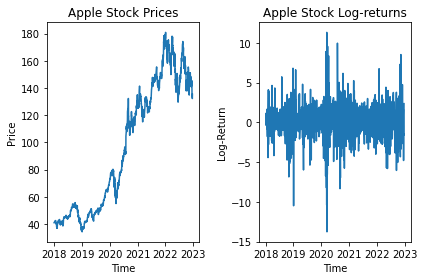

In [5]:
#================== Visual representation ===================

# Check the stock price's fluctuation
plt.subplot(1, 2, 1)
plt.plot(df['Adj Close'])
plt.title("Apple Stock Prices")
plt.xlabel('Time')
plt.ylabel('Price')
# Check the evolution of log-returns
plt.subplot(1, 2, 2)
plt.plot(df_logret)
plt.title("Apple Stock Log-returns")
plt.xlabel('Time')
plt.ylabel('Log-Return')
plt.tight_layout()

## Step 2: Fit ARMA and GARCH models

In [6]:
#================== Stationary Assumption Test: Augmented Dickey-Fuller ===================

# Run ADF test and present outputs in a straightforward dataframe
test = adfuller(df_logret)
df_adf = pd.DataFrame(index=['Test Statistic Value', "p-value", "Lags Used", "Number of Observations Used","Critical Value(1%)","Critical Value(5%)","Critical Value(10%)"],columns=['Output'])
df_adf['Output']['Test Statistic Value'] = test[0]
df_adf['Output']['p-value'] = test[1]
df_adf['Output']['Lags Used'] = test[2]
df_adf['Output']['Number of Observations Used'] = test[3]
df_adf['Output']['Critical Value(1%)'] = test[4]['1%']
df_adf['Output']['Critical Value(5%)'] = test[4]['5%']
df_adf['Output']['Critical Value(10%)'] = test[4]['10%']
df_adf

,Output
Test Statistic Value,-11.082035
p-value,0.0
Lags Used,8
Number of Observations Used,1242
Critical Value(1%),-3.435626
Critical Value(5%),-2.86387
Critical Value(10%),-2.56801


<div style="text-align: justify">The null hypothesis is rejected since the test's p-value is below the 1% threshold. Therefore, the process is <strong>stationary</strong> and data's properties are fit for forecasting inference.</div> 

fitting: ar:0 - ma:0
fitting: ar:0 - ma:1
fitting: ar:0 - ma:2
fitting: ar:0 - ma:3
fitting: ar:0 - ma:4
fitting: ar:0 - ma:5
fitting: ar:1 - ma:0
fitting: ar:1 - ma:1
fitting: ar:1 - ma:2
fitting: ar:1 - ma:3
fitting: ar:1 - ma:4
fitting: ar:1 - ma:5
fitting: ar:2 - ma:0
fitting: ar:2 - ma:1
fitting: ar:2 - ma:2
fitting: ar:2 - ma:3
fitting: ar:2 - ma:4
fitting: ar:2 - ma:5
fitting: ar:3 - ma:0
fitting: ar:3 - ma:1
fitting: ar:3 - ma:2
fitting: ar:3 - ma:3
fitting: ar:3 - ma:4
fitting: ar:3 - ma:5
fitting: ar:4 - ma:0
fitting: ar:4 - ma:1
fitting: ar:4 - ma:2
fitting: ar:4 - ma:3
fitting: ar:4 - ma:4
fitting: ar:4 - ma:5
fitting: ar:5 - ma:0
fitting: ar:5 - ma:1
fitting: ar:5 - ma:2
fitting: ar:5 - ma:3
fitting: ar:5 - ma:4
fitting: ar:5 - ma:5
criterion
     ar_order  ma_order       aic       bic
0          0         0  5.053090  5.063224
1          0         1  5.039215  5.054417
2          0         2  5.040839  5.061109
3          0         3  5.042616  5.067953
4          0      

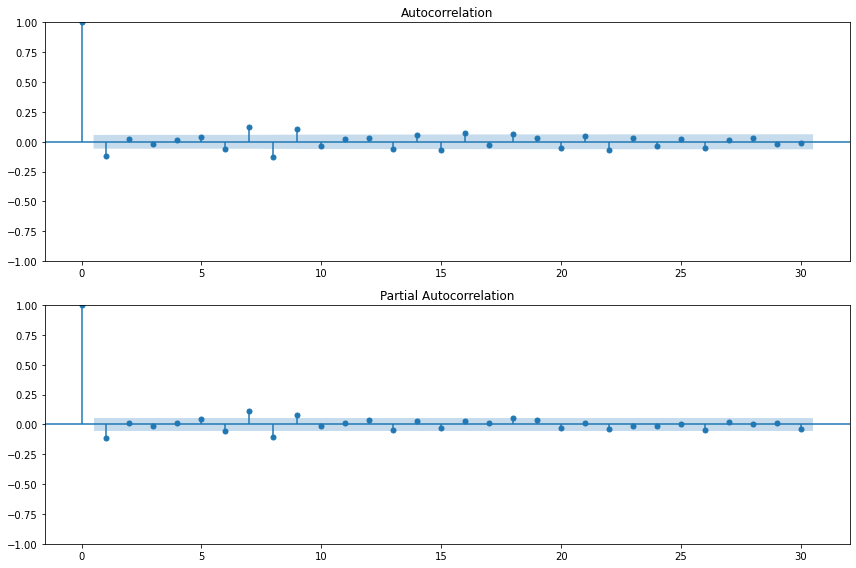

In [7]:
#================== Box-Jenkins Method to fit ARIMA process ===================

## Identification: Choose optimal parameters orders based on ACF/PACF and information criterions 

# Graphical analysis
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_train, lags=30, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_train, lags=30, ax=ax2)
plt.tight_layout()

# Parameters AIC/BIC analysis
ar_order = [0, 1, 2, 3, 4, 5]
ma_order = [0, 1, 2, 3, 4, 5]
arma_res = [list(orders) for orders in product(ar_order, ma_order)]

## Estimation: Fit ARMA model on train dataset
for n in arma_res:
    print('fitting: ar:{} - ma:{}'.format(*n)) 
    try:
        arma_model  = tsa.arima.model.ARIMA(df_train, order= (n[0], 0, n[1])).fit()
        ## Diagnostic: Compute and analyze the information criterion + Stationarity confirmed with ADF
        n.extend([arma_model.aic / 1e3, arma_model.bic / 1e3])
    except Exception as exception:
        print(exception.__str__())
        n.extend([np.NaN, np.NaN])
    
res = pd.DataFrame(arma_res, columns = ['ar_order', 'ma_order', 'aic', 'bic'])
print('criterion\n', res)

# Confirm the optimal parameter order 
opti_order = sm.tsa.arma_order_select_ic(df_train,max_ar=5,max_ma=5,ic='bic')['bic_min_order']
print()
print(f'The optimal ARMA model to fit Apple daily log returns is the ARMA{opti_order}')

<div style="text-align: justify">Despite unclear graphical inference, the BIC criterion (which is better for large samples) allows us to identify <strong>ARMA(2,3) model as the best fit</strong> for our data.</div>

In [8]:
#===== Analyze for GARCH effects using the Jarque-Bera test on the standardized residuals =======================

# Compute standardized residuals
df_train_std = (df_train - np.mean(df_train))/ np.std(df_train)
nb_obs = len(df_train_std)

# Run the Jarque-Bera test on standardized residuals
jb = sm.stats.stattools.jarque_bera(df_train_std, axis=0)
df_jb = pd.DataFrame(index=['T-stat', "P-value", "Skewness", "Kurtosis"],columns=['Output'])
df_jb['Output']['T-stat'] = jb[0]
df_jb['Output']['P-value'] = jb[1]
df_jb['Output']['Skewness'] = jb[2]
df_jb['Output']['Kurtosis'] = jb[3]
print(df_jb)

               Output
T-stat    1252.198439
P-value           0.0
Skewness    -0.319214
Kurtosis     8.021239


<div style="text-align: justify">The Jarque-Bera tests the model's goodness-of-fit and indicates on its distribution. Since the p-value is below the 1% threshold, we <strong> reject the null hypothesis</strong> of residuals' normal distribution. Therefore, we confirm the presence of a GARCH effect. One could use a different distribution for GARCH, one with fatter tails and that takes into account the skewness.</div>

<div style="text-align: justify">As we have seen in class, GARCH(1,1) will be parsimonious and sufficiently flexible so that higher orders are rarely used:</div>

Iteration:      1,   Func. Count:      7,   Neg. LLF: 6120.617714216662
Iteration:      2,   Func. Count:     17,   Neg. LLF: 53505.429787248264
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2603.4752996119605
Iteration:      4,   Func. Count:     35,   Neg. LLF: 2575.4651629840537
Iteration:      5,   Func. Count:     43,   Neg. LLF: 2359.8841866466387
Iteration:      6,   Func. Count:     50,   Neg. LLF: 2356.158796056219
Iteration:      7,   Func. Count:     56,   Neg. LLF: 2356.071058190705
Iteration:      8,   Func. Count:     62,   Neg. LLF: 2356.0629445302047
Iteration:      9,   Func. Count:     68,   Neg. LLF: 2356.06087675463
Iteration:     10,   Func. Count:     74,   Neg. LLF: 2356.060535437932
Iteration:     11,   Func. Count:     80,   Neg. LLF: 2356.060471660766
Iteration:     12,   Func. Count:     85,   Neg. LLF: 2356.0604716607586
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2356.060471660766
            Iterations:

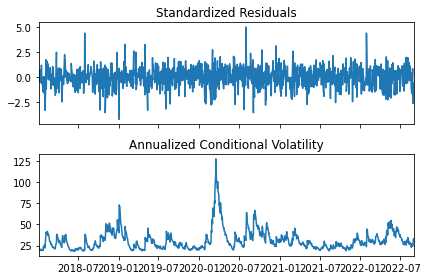

In [9]:
#===== GARCH(1,1) model fit and analysis =======================

# Run the model and analyze its parameters
arch = arch_model(df_train,p=1, o=0, q=1, mean='AR', lags=0, dist='t') 
res = arch.fit()
print(res.summary())
# Fine tune the analysis with visual representation of residuals' behavior
fig = res.plot(annualize='D')
fig.tight_layout()

Looking at this summary, we can conclude the presence of a GARCH(1,1).

## Step 3: Forcasting 1- and 20-steps ahead:

In [10]:
#===== Key forecasting functions =======================

def fixed_window(steps, df_test, df):
    idx = df_test.index
    data_shifted = df.shift(steps).loc[idx].apply(np.log)
    # Fit an ARMA on data and GARCH on its residuals
    arma_model  = tsa.arima.model.ARIMA(df_train, order=(2,0,3)).fit()
    garch_res = arch_model(df_train_std,p=1, o=0, q=1, mean='AR', lags=0, dist='t').fit()
    # Forecast values for both models for inputed steps
    forecast_arma = arma_model.predict(n_periods=steps)[0]
    forecast_garch = garch_res.forecast(horizon=steps, reindex=False)
    predicted_et = forecast_garch.mean['h.'+ str(steps)].iloc[-1]
    # Define the prediction output 
    prediction = forecast_arma + predicted_et
    prediction = pd.DataFrame(prediction, columns=['Fixed'], index=idx).cumsum()
    
    return prediction

def recursive_window(steps, df_test, df):
    forecast = []
    idx = df_test.index
    data_shifted = df.shift(steps).loc[idx].apply(np.log)
    for dt in df_test.index:
        data = df_logret.loc[df_logret.index < dt]
        # Fit an ARMA on data and GARCH on its residuals
        arma_model  = tsa.arima.model.ARIMA(data, order=(2,0,3)).fit()
        garch_res = arch_model(data,p=1, o=0, q=1, mean='AR', lags=0, dist='t').fit()
        # Forecast values for both models for inputed steps
        forecast_arma = arma_model.predict(n_periods=steps)[0]
        forecast_garch = garch_res.forecast(horizon=steps, reindex=False)
        predicted_et = forecast_garch.mean['h.'+ str(steps)].iloc[-1]
        # Define the prediction output 
        prediction = forecast_arma + predicted_et
        forecast.append(prediction.tolist())

    forecast = pd.DataFrame(forecast, columns=['Recursive'], index=idx)
    return forecast

def rolling_window(steps,df_test,df):
    forecast = []
    roll_freq = 200
    idx = df_test.index
    data_shifted = df.shift(steps).loc[idx].apply(np.log)
    
    for dt in df_test.index:
        data = df_logret.loc[df_logret.index < dt]
        # Fit an ARMA on data and GARCH on its residuals
        arma_model  = tsa.arima.model.ARIMA(data.iloc[-roll_freq:], order=(2,0,3)).fit()
        garch_res = arch_model(data,p=1, o=0, q=1, mean='AR', lags=0, dist='t').fit()
        # Forecast values for both models for inputed steps
        forecast_arma = arma_model.predict(n_periods=steps)[0]
        forecast_garch = garch_res.forecast(horizon=steps, reindex=False)
        predicted_et = forecast_garch.mean['h.'+ str(steps)].iloc[-1]
        # Define the prediction output
        prediction = forecast_arma + predicted_et
        forecast.append(prediction.tolist())

    forecast = pd.DataFrame(forecast, columns=['Rolling'], index=idx)
    return forecast

In [11]:
#===== 1-step ahead forecasts =======================
steps = 1
idx = df_test.index
data_shifted = df.shift(steps).loc[idx].apply(np.log)

# Adjusted close price
obs = df.loc[df_test.index].apply(np.log)

# Fixed window forecast
forecast_fixed = fixed_window(steps, df_test, df).add(data_shifted.squeeze(),axis=0)

# Recursive window forecast
forecast_recursive = recursive_window(steps, df_test, df).add(data_shifted.squeeze(),axis=0)

# Rolling window forecast
forecast_rolling = rolling_window(steps, df_test, df).add(data_shifted.squeeze(),axis=0)

# Global forecast overview by merging outputs
list = [forecast_recursive,forecast_rolling, obs]
forecast_overview = forecast_fixed
for i in range(len(list)):
    forecast_overview = pd.merge(forecast_overview,list[i], left_index=True, right_index=True)
forecast_overview

Iteration:      1,   Func. Count:      7,   Neg. LLF: 6988.224375263742
Iteration:      2,   Func. Count:     17,   Neg. LLF: 50688.60566980837
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2035.8088276138851
Iteration:      4,   Func. Count:     34,   Neg. LLF: 2907.448472559479
Iteration:      5,   Func. Count:     42,   Neg. LLF: 2613.0807163908876
Iteration:      6,   Func. Count:     49,   Neg. LLF: 1495.9852749960846
Iteration:      7,   Func. Count:     55,   Neg. LLF: 1495.9396291204237
Iteration:      8,   Func. Count:     61,   Neg. LLF: 1495.9326753514288
Iteration:      9,   Func. Count:     67,   Neg. LLF: 1495.9308521666105
Iteration:     10,   Func. Count:     73,   Neg. LLF: 1495.9306201237564
Iteration:     11,   Func. Count:     79,   Neg. LLF: 1495.9305506306682
Iteration:     12,   Func. Count:     85,   Neg. LLF: 1495.9305500117587
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1495.9305500117587
            Iterat

Iteration:      1,   Func. Count:      7,   Neg. LLF: 6143.256362718113
Iteration:      2,   Func. Count:     17,   Neg. LLF: 54739.03347511635
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2608.6697595298483
Iteration:      4,   Func. Count:     35,   Neg. LLF: 2589.6322809535163
Iteration:      5,   Func. Count:     43,   Neg. LLF: 2374.8707275071265
Iteration:      6,   Func. Count:     50,   Neg. LLF: 2370.3418880194504
Iteration:      7,   Func. Count:     56,   Neg. LLF: 2370.2488276804934
Iteration:      8,   Func. Count:     62,   Neg. LLF: 2370.239817414402
Iteration:      9,   Func. Count:     68,   Neg. LLF: 2370.2376773963824
Iteration:     10,   Func. Count:     74,   Neg. LLF: 2370.2373011348195
Iteration:     11,   Func. Count:     80,   Neg. LLF: 2370.237229562218
Iteration:     12,   Func. Count:     85,   Neg. LLF: 2370.237229562209
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2370.237229562218
            Iteration

Iteration:      1,   Func. Count:      7,   Neg. LLF: 6230.00663110016
Iteration:      2,   Func. Count:     17,   Neg. LLF: 53606.793809721086
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2633.112298955929
Iteration:      4,   Func. Count:     35,   Neg. LLF: 2606.958237639314
Iteration:      5,   Func. Count:     43,   Neg. LLF: 2426.5837872145503
Iteration:      6,   Func. Count:     50,   Neg. LLF: 2390.5361283676325
Iteration:      7,   Func. Count:     56,   Neg. LLF: 2390.3499346280128
Iteration:      8,   Func. Count:     62,   Neg. LLF: 2390.3273834869415
Iteration:      9,   Func. Count:     68,   Neg. LLF: 2390.323249681586
Iteration:     10,   Func. Count:     74,   Neg. LLF: 2390.322611817971
Iteration:     11,   Func. Count:     80,   Neg. LLF: 2390.3223663499157
Iteration:     12,   Func. Count:     85,   Neg. LLF: 2390.3223663499175
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2390.3223663499157
            Iteration

Iteration:      1,   Func. Count:      7,   Neg. LLF: 6308.39881934167
Iteration:      2,   Func. Count:     17,   Neg. LLF: 54249.443271623786
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2661.7975790238597
Iteration:      4,   Func. Count:     35,   Neg. LLF: 2624.9991156055967
Iteration:      5,   Func. Count:     43,   Neg. LLF: 2470.1515523537428
Iteration:      6,   Func. Count:     50,   Neg. LLF: 2410.5678255355133
Iteration:      7,   Func. Count:     56,   Neg. LLF: 2410.3733657382377
Iteration:      8,   Func. Count:     62,   Neg. LLF: 2410.349951262493
Iteration:      9,   Func. Count:     68,   Neg. LLF: 2410.345669219306
Iteration:     10,   Func. Count:     74,   Neg. LLF: 2410.345024741311
Iteration:     11,   Func. Count:     80,   Neg. LLF: 2410.3448002742507
Iteration:     12,   Func. Count:     85,   Neg. LLF: 2410.3448002742534
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2410.3448002742507
            Iteratio

Iteration:      1,   Func. Count:      7,   Neg. LLF: 6380.462878136541
Iteration:      2,   Func. Count:     17,   Neg. LLF: 54612.12921621776
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2689.1134372088572
Iteration:      4,   Func. Count:     34,   Neg. LLF: 2644.517413282694
Iteration:      5,   Func. Count:     42,   Neg. LLF: 3580.0441846665112
Iteration:      6,   Func. Count:     49,   Neg. LLF: 2428.8998125566636
Iteration:      7,   Func. Count:     55,   Neg. LLF: 2428.780890256043
Iteration:      8,   Func. Count:     61,   Neg. LLF: 2428.7648551744473
Iteration:      9,   Func. Count:     67,   Neg. LLF: 2428.762281751198
Iteration:     10,   Func. Count:     73,   Neg. LLF: 2428.7617407611483
Iteration:     11,   Func. Count:     79,   Neg. LLF: 2428.7615992308047
Iteration:     12,   Func. Count:     84,   Neg. LLF: 2428.7615992308074
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2428.7615992308047
            Iteratio

Iteration:      1,   Func. Count:      7,   Neg. LLF: 6396.721972479141
Iteration:      2,   Func. Count:     17,   Neg. LLF: 55666.86966279865
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2697.4236405733063
Iteration:      4,   Func. Count:     35,   Neg. LLF: 2664.1686267101063
Iteration:      5,   Func. Count:     43,   Neg. LLF: 2469.578754736393
Iteration:      6,   Func. Count:     50,   Neg. LLF: 2445.2697361240475
Iteration:      7,   Func. Count:     56,   Neg. LLF: 2445.079645218804
Iteration:      8,   Func. Count:     62,   Neg. LLF: 2445.0557982438722
Iteration:      9,   Func. Count:     68,   Neg. LLF: 2445.0519861814446
Iteration:     10,   Func. Count:     74,   Neg. LLF: 2445.0514767691448
Iteration:     11,   Func. Count:     80,   Neg. LLF: 2445.0512963623178
Iteration:     12,   Func. Count:     85,   Neg. LLF: 2445.0512963623196
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2445.0512963623178
            Iterati

Iteration:      1,   Func. Count:      7,   Neg. LLF: 6475.679274344736
Iteration:      2,   Func. Count:     17,   Neg. LLF: 55534.40271165804
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2729.315428030275
Iteration:      4,   Func. Count:     34,   Neg. LLF: 2682.9069538365707
Iteration:      5,   Func. Count:     42,   Neg. LLF: 3638.9421245399394
Iteration:      6,   Func. Count:     49,   Neg. LLF: 2469.1653231711152
Iteration:      7,   Func. Count:     55,   Neg. LLF: 2469.040466917295
Iteration:      8,   Func. Count:     61,   Neg. LLF: 2469.025538130937
Iteration:      9,   Func. Count:     67,   Neg. LLF: 2469.022749849013
Iteration:     10,   Func. Count:     73,   Neg. LLF: 2469.022234223327
Iteration:     11,   Func. Count:     79,   Neg. LLF: 2469.022111733786
Iteration:     12,   Func. Count:     84,   Neg. LLF: 2469.022111733785
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2469.022111733786
            Iterations: 1

Iteration:      1,   Func. Count:      7,   Neg. LLF: 6463.681842161649
Iteration:      2,   Func. Count:     17,   Neg. LLF: 55262.42713172511
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2742.16196960906
Iteration:      4,   Func. Count:     34,   Neg. LLF: 2706.6912335663883
Iteration:      5,   Func. Count:     42,   Neg. LLF: 3637.1862726669897
Iteration:      6,   Func. Count:     49,   Neg. LLF: 2490.486433503166
Iteration:      7,   Func. Count:     55,   Neg. LLF: 2490.2941716153664
Iteration:      8,   Func. Count:     61,   Neg. LLF: 2490.2676346728604
Iteration:      9,   Func. Count:     67,   Neg. LLF: 2490.2620184511507
Iteration:     10,   Func. Count:     73,   Neg. LLF: 2490.2611525897964
Iteration:     11,   Func. Count:     79,   Neg. LLF: 2490.26088142294
Iteration:     12,   Func. Count:     85,   Neg. LLF: 2490.2608805318764
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2490.2608805318764
            Iterations

Iteration:      1,   Func. Count:      7,   Neg. LLF: 6516.382764173262
Iteration:      2,   Func. Count:     17,   Neg. LLF: 55680.11431664079
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2768.9234672652924
Iteration:      4,   Func. Count:     34,   Neg. LLF: 2724.6367249424343
Iteration:      5,   Func. Count:     42,   Neg. LLF: 3667.1678951972117
Iteration:      6,   Func. Count:     49,   Neg. LLF: 2509.593308261225
Iteration:      7,   Func. Count:     55,   Neg. LLF: 2509.4273997580594
Iteration:      8,   Func. Count:     61,   Neg. LLF: 2509.4065152615917
Iteration:      9,   Func. Count:     67,   Neg. LLF: 2509.402403849913
Iteration:     10,   Func. Count:     73,   Neg. LLF: 2509.4018131979874
Iteration:     11,   Func. Count:     79,   Neg. LLF: 2509.4016465511468
Iteration:     12,   Func. Count:     84,   Neg. LLF: 2509.4016465511495
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2509.4016465511468
            Iterati

Iteration:      1,   Func. Count:      7,   Neg. LLF: 6574.378601731544
Iteration:      2,   Func. Count:     17,   Neg. LLF: 55436.04065654273
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2795.991192189686
Iteration:      4,   Func. Count:     34,   Neg. LLF: 2740.0837489247806
Iteration:      5,   Func. Count:     42,   Neg. LLF: 3680.5563318849354
Iteration:      6,   Func. Count:     49,   Neg. LLF: 2524.6775126724924
Iteration:      7,   Func. Count:     55,   Neg. LLF: 2524.5211426037245
Iteration:      8,   Func. Count:     61,   Neg. LLF: 2524.498977143983
Iteration:      9,   Func. Count:     67,   Neg. LLF: 2524.4952444630662
Iteration:     10,   Func. Count:     73,   Neg. LLF: 2524.494634405681
Iteration:     11,   Func. Count:     79,   Neg. LLF: 2524.4944504968616
Iteration:     12,   Func. Count:     84,   Neg. LLF: 2524.494450496866
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2524.4944504968616
            Iteration

Iteration:      1,   Func. Count:      7,   Neg. LLF: 6122.461493256787
Iteration:      2,   Func. Count:     17,   Neg. LLF: 53288.804353138985
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2606.6802327866526
Iteration:      4,   Func. Count:     35,   Neg. LLF: 2576.944790272874
Iteration:      5,   Func. Count:     43,   Neg. LLF: 2362.053658883486
Iteration:      6,   Func. Count:     50,   Neg. LLF: 2357.6106674073835
Iteration:      7,   Func. Count:     56,   Neg. LLF: 2357.5004591814945
Iteration:      8,   Func. Count:     62,   Neg. LLF: 2357.4896299707834
Iteration:      9,   Func. Count:     68,   Neg. LLF: 2357.487215637416
Iteration:     10,   Func. Count:     74,   Neg. LLF: 2357.486807655317
Iteration:     11,   Func. Count:     80,   Neg. LLF: 2357.486710502165
Iteration:     12,   Func. Count:     86,   Neg. LLF: 2357.4867098504146
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2357.4867098504146
            Iteration

Iteration:      1,   Func. Count:      7,   Neg. LLF: 6191.285752271022
Iteration:      2,   Func. Count:     17,   Neg. LLF: 53612.26617588653
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2618.7194729482326
Iteration:      4,   Func. Count:     35,   Neg. LLF: 2592.1270895598373
Iteration:      5,   Func. Count:     43,   Neg. LLF: 2411.2542050168736
Iteration:      6,   Func. Count:     50,   Neg. LLF: 2378.054726605418
Iteration:      7,   Func. Count:     56,   Neg. LLF: 2377.8550583406127
Iteration:      8,   Func. Count:     62,   Neg. LLF: 2377.8293684918244
Iteration:      9,   Func. Count:     68,   Neg. LLF: 2377.824500507578
Iteration:     10,   Func. Count:     74,   Neg. LLF: 2377.823736830681
Iteration:     11,   Func. Count:     80,   Neg. LLF: 2377.823433476434
Iteration:     12,   Func. Count:     85,   Neg. LLF: 2377.823433476437
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2377.823433476434
            Iterations:

Iteration:      1,   Func. Count:      7,   Neg. LLF: 6242.3142258467815
Iteration:      2,   Func. Count:     17,   Neg. LLF: 53619.240690649705
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2638.2725145679524
Iteration:      4,   Func. Count:     35,   Neg. LLF: 2611.2512684468898
Iteration:      5,   Func. Count:     43,   Neg. LLF: 2448.587778677349
Iteration:      6,   Func. Count:     50,   Neg. LLF: 2394.0856106601473
Iteration:      7,   Func. Count:     56,   Neg. LLF: 2393.9040222229996
Iteration:      8,   Func. Count:     62,   Neg. LLF: 2393.8832104166377
Iteration:      9,   Func. Count:     68,   Neg. LLF: 2393.879297003741
Iteration:     10,   Func. Count:     74,   Neg. LLF: 2393.8786702076995
Iteration:     11,   Func. Count:     80,   Neg. LLF: 2393.878427893289
Iteration:     12,   Func. Count:     85,   Neg. LLF: 2393.8784278932917
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2393.878427893289
            Iterati

Iteration:      1,   Func. Count:      7,   Neg. LLF: 6320.234657139125
Iteration:      2,   Func. Count:     17,   Neg. LLF: 53815.47221584899
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2664.6721487111736
Iteration:      4,   Func. Count:     35,   Neg. LLF: 2628.2171092795606
Iteration:      5,   Func. Count:     43,   Neg. LLF: 2624.284675552267
Iteration:      6,   Func. Count:     50,   Neg. LLF: 2414.0299470856107
Iteration:      7,   Func. Count:     56,   Neg. LLF: 2413.8396630123534
Iteration:      8,   Func. Count:     62,   Neg. LLF: 2413.8185887595137
Iteration:      9,   Func. Count:     68,   Neg. LLF: 2413.8144255607813
Iteration:     10,   Func. Count:     74,   Neg. LLF: 2413.8137867326495
Iteration:     11,   Func. Count:     80,   Neg. LLF: 2413.8135738758156
Iteration:     12,   Func. Count:     85,   Neg. LLF: 2413.8135738758156
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2413.8135738758156
            Iterat

Iteration:      1,   Func. Count:      7,   Neg. LLF: 6375.182717305337
Iteration:      2,   Func. Count:     17,   Neg. LLF: 55063.68483964255
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2688.531622951793
Iteration:      4,   Func. Count:     34,   Neg. LLF: 2647.697206865496
Iteration:      5,   Func. Count:     42,   Neg. LLF: 2926.1651249298548
Iteration:      6,   Func. Count:     49,   Neg. LLF: 2433.2068838751193
Iteration:      7,   Func. Count:     55,   Neg. LLF: 2433.0932317968864
Iteration:      8,   Func. Count:     61,   Neg. LLF: 2433.0772382843243
Iteration:      9,   Func. Count:     67,   Neg. LLF: 2433.074698834559
Iteration:     10,   Func. Count:     73,   Neg. LLF: 2433.0741494995846
Iteration:     11,   Func. Count:     79,   Neg. LLF: 2433.0740072969397
Iteration:     12,   Func. Count:     84,   Neg. LLF: 2433.0740072969425
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2433.0740072969397
            Iteratio

Iteration:      1,   Func. Count:      7,   Neg. LLF: 6361.240861131562
Iteration:      2,   Func. Count:     17,   Neg. LLF: 56354.85846595574
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2697.3448808009475
Iteration:      4,   Func. Count:     35,   Neg. LLF: 2671.3906163001648
Iteration:      5,   Func. Count:     43,   Neg. LLF: 2553.2414441069923
Iteration:      6,   Func. Count:     50,   Neg. LLF: 2454.426407572571
Iteration:      7,   Func. Count:     56,   Neg. LLF: 2454.2443185107413
Iteration:      8,   Func. Count:     62,   Neg. LLF: 2454.222136376108
Iteration:      9,   Func. Count:     68,   Neg. LLF: 2454.2172128641414
Iteration:     10,   Func. Count:     74,   Neg. LLF: 2454.216459658239
Iteration:     11,   Func. Count:     80,   Neg. LLF: 2454.21625301189
Iteration:     12,   Func. Count:     85,   Neg. LLF: 2454.2162530118912
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2454.21625301189
            Iterations: 

Iteration:      1,   Func. Count:      7,   Neg. LLF: 6505.277744378203
Iteration:      2,   Func. Count:     17,   Neg. LLF: 55516.84999687283
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2739.493003486391
Iteration:      4,   Func. Count:     34,   Neg. LLF: 2689.033505900012
Iteration:      5,   Func. Count:     42,   Neg. LLF: 3648.13206543002
Iteration:      6,   Func. Count:     49,   Neg. LLF: 2474.0255420226845
Iteration:      7,   Func. Count:     55,   Neg. LLF: 2473.899711530614
Iteration:      8,   Func. Count:     61,   Neg. LLF: 2473.8853730436913
Iteration:      9,   Func. Count:     67,   Neg. LLF: 2473.8828236267827
Iteration:     10,   Func. Count:     73,   Neg. LLF: 2473.882371548194
Iteration:     11,   Func. Count:     79,   Neg. LLF: 2473.882263074981
Iteration:     12,   Func. Count:     84,   Neg. LLF: 2473.88226307498
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2473.882263074981
            Iterations: 12


Iteration:      1,   Func. Count:      7,   Neg. LLF: 6487.5240858306815
Iteration:      2,   Func. Count:     17,   Neg. LLF: 54991.4101932626
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2750.7831799441046
Iteration:      4,   Func. Count:     34,   Neg. LLF: 2710.684593910716
Iteration:      5,   Func. Count:     42,   Neg. LLF: 3642.141042259358
Iteration:      6,   Func. Count:     49,   Neg. LLF: 2494.6478335521333
Iteration:      7,   Func. Count:     55,   Neg. LLF: 2494.461075910581
Iteration:      8,   Func. Count:     61,   Neg. LLF: 2494.4350777756317
Iteration:      9,   Func. Count:     67,   Neg. LLF: 2494.429754472907
Iteration:     10,   Func. Count:     73,   Neg. LLF: 2494.4289077563835
Iteration:     11,   Func. Count:     79,   Neg. LLF: 2494.4286418587826
Iteration:     12,   Func. Count:     85,   Neg. LLF: 2494.428640948844
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2494.428640948844
            Iterations:

Iteration:      1,   Func. Count:      7,   Neg. LLF: 6530.447498710465
Iteration:      2,   Func. Count:     17,   Neg. LLF: 55629.40300337755
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2774.775777274857
Iteration:      4,   Func. Count:     34,   Neg. LLF: 2728.6125187980488
Iteration:      5,   Func. Count:     42,   Neg. LLF: 3665.804510279906
Iteration:      6,   Func. Count:     49,   Neg. LLF: 2513.091105119789
Iteration:      7,   Func. Count:     55,   Neg. LLF: 2512.909669513695
Iteration:      8,   Func. Count:     61,   Neg. LLF: 2512.8851387937384
Iteration:      9,   Func. Count:     67,   Neg. LLF: 2512.8804822448637
Iteration:     10,   Func. Count:     73,   Neg. LLF: 2512.8798000403135
Iteration:     11,   Func. Count:     79,   Neg. LLF: 2512.8795927048327
Iteration:     12,   Func. Count:     85,   Neg. LLF: 2512.8795920661687
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2512.8795920661687
            Iteration

Iteration:      1,   Func. Count:      7,   Neg. LLF: 6585.238917300545
Iteration:      2,   Func. Count:     17,   Neg. LLF: 55398.81880717195
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2803.3793984230024
Iteration:      4,   Func. Count:     34,   Neg. LLF: 2744.415491710736
Iteration:      5,   Func. Count:     42,   Neg. LLF: 3684.2205928954336
Iteration:      6,   Func. Count:     49,   Neg. LLF: 2528.223425792609
Iteration:      7,   Func. Count:     55,   Neg. LLF: 2528.078565107548
Iteration:      8,   Func. Count:     61,   Neg. LLF: 2528.057414350379
Iteration:      9,   Func. Count:     67,   Neg. LLF: 2528.0539883725723
Iteration:     10,   Func. Count:     73,   Neg. LLF: 2528.053400508433
Iteration:     11,   Func. Count:     79,   Neg. LLF: 2528.0532251029326
Iteration:     12,   Func. Count:     84,   Neg. LLF: 2528.0532251029367
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2528.0532251029326
            Iterations

,Fixed,Recursive,Rolling,Adj Close
Date,,,,
2022-09-01,5.215335,5.375340,5.282583,5.060684
2022-09-02,5.379376,5.378030,5.291155,5.046980
2022-09-06,5.525018,5.355979,5.265165,5.038731
2022-09-07,5.676115,5.350737,5.242079,5.047942
2022-09-08,5.844672,5.359126,5.242847,5.038278
...,...,...,...,...
2022-12-15,16.755918,5.265836,5.069963,4.916325
2022-12-16,16.867276,5.190700,4.997887,4.901639
2022-12-19,17.011936,5.181183,4.997342,4.885601


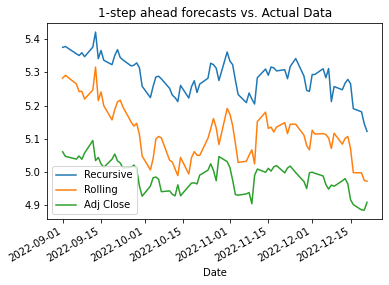


 forecasts 
                 Fixed  Recursive   Rolling  Adj Close
Date                                                 
2022-09-01   5.215335   5.375340  5.282583   5.060684
2022-09-02   5.379376   5.378030  5.291155   5.046980
2022-09-06   5.525018   5.355979  5.265165   5.038731
2022-09-07   5.676115   5.350737  5.242079   5.047942
2022-09-08   5.844672   5.359126  5.242847   5.038278
...               ...        ...       ...        ...
2022-12-15  16.755918   5.265836  5.069963   4.916325
2022-12-16  16.867276   5.190700  4.997887   4.901639
2022-12-19  17.011936   5.181183  4.997342   4.885601
2022-12-20  17.155245   5.145268  4.974195   4.885072
2022-12-21  17.314062   5.122133  4.972214   4.908603

[78 rows x 4 columns]

 MAE 
 Recursive    2.357345
Rolling      1.020828
dtype: float64

 RMSE 
 Recursive    0.848639
Rolling      0.389806
dtype: float64


In [12]:
#=================== Plot forecasts and compute errors ===========================================================================    

# Plot the forecast overview of recursive and rolling windows against actual data  
forecast_overview.iloc[:,1:].plot()
plt.title('1-step ahead forecasts vs. Actual Data')
plt.show()


# Compute the MAE/RMSE and analyze full forecast table --> Select modeln with lowest RMSE
epsilon = forecast_overview.iloc[:,1:3].sub(obs.squeeze(), axis=0)
mae = epsilon.abs().sum(axis=0)/10
rmse = ((epsilon**2).sum(axis=0)/10)**.5
    
print('\n forecasts \n', forecast_overview)
print('\n MAE \n', mae) 
print('\n RMSE \n', rmse) 

In [13]:
#===== 20-step ahead forecasts =======================
steps = 20
idx = df_test.index
data_shifted = df.shift(steps).loc[idx].apply(np.log)

# Adjusted close price
obs = df.loc[df_test.index].apply(np.log)

# Fixed window forecast
forecast_fixed = fixed_window(steps, df_test, df).add(data_shifted.squeeze(),axis=0)

# Recursive window forecast
forecast_recursive = recursive_window(steps, df_test, df).add(data_shifted.squeeze(),axis=0)

# Rolling window forecast
forecast_rolling = rolling_window(steps, df_test, df).add(data_shifted.squeeze(),axis=0)

# Global forecast overview by merging outputs
list = [forecast_recursive,forecast_rolling, obs]
forecast_overview = forecast_fixed
for i in range(len(list)):
    forecast_overview = pd.merge(forecast_overview,list[i], left_index=True, right_index=True)

Iteration:      1,   Func. Count:      7,   Neg. LLF: 6988.224375263742
Iteration:      2,   Func. Count:     17,   Neg. LLF: 50688.60566980837
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2035.8088276138851
Iteration:      4,   Func. Count:     34,   Neg. LLF: 2907.448472559479
Iteration:      5,   Func. Count:     42,   Neg. LLF: 2613.0807163908876
Iteration:      6,   Func. Count:     49,   Neg. LLF: 1495.9852749960846
Iteration:      7,   Func. Count:     55,   Neg. LLF: 1495.9396291204237
Iteration:      8,   Func. Count:     61,   Neg. LLF: 1495.9326753514288
Iteration:      9,   Func. Count:     67,   Neg. LLF: 1495.9308521666105
Iteration:     10,   Func. Count:     73,   Neg. LLF: 1495.9306201237564
Iteration:     11,   Func. Count:     79,   Neg. LLF: 1495.9305506306682
Iteration:     12,   Func. Count:     85,   Neg. LLF: 1495.9305500117587
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1495.9305500117587
            Iterat

Iteration:      1,   Func. Count:      7,   Neg. LLF: 6143.256362718113
Iteration:      2,   Func. Count:     17,   Neg. LLF: 54739.03347511635
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2608.6697595298483
Iteration:      4,   Func. Count:     35,   Neg. LLF: 2589.6322809535163
Iteration:      5,   Func. Count:     43,   Neg. LLF: 2374.8707275071265
Iteration:      6,   Func. Count:     50,   Neg. LLF: 2370.3418880194504
Iteration:      7,   Func. Count:     56,   Neg. LLF: 2370.2488276804934
Iteration:      8,   Func. Count:     62,   Neg. LLF: 2370.239817414402
Iteration:      9,   Func. Count:     68,   Neg. LLF: 2370.2376773963824
Iteration:     10,   Func. Count:     74,   Neg. LLF: 2370.2373011348195
Iteration:     11,   Func. Count:     80,   Neg. LLF: 2370.237229562218
Iteration:     12,   Func. Count:     85,   Neg. LLF: 2370.237229562209
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2370.237229562218
            Iteration

Iteration:      1,   Func. Count:      7,   Neg. LLF: 6230.00663110016
Iteration:      2,   Func. Count:     17,   Neg. LLF: 53606.793809721086
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2633.112298955929
Iteration:      4,   Func. Count:     35,   Neg. LLF: 2606.958237639314
Iteration:      5,   Func. Count:     43,   Neg. LLF: 2426.5837872145503
Iteration:      6,   Func. Count:     50,   Neg. LLF: 2390.5361283676325
Iteration:      7,   Func. Count:     56,   Neg. LLF: 2390.3499346280128
Iteration:      8,   Func. Count:     62,   Neg. LLF: 2390.3273834869415
Iteration:      9,   Func. Count:     68,   Neg. LLF: 2390.323249681586
Iteration:     10,   Func. Count:     74,   Neg. LLF: 2390.322611817971
Iteration:     11,   Func. Count:     80,   Neg. LLF: 2390.3223663499157
Iteration:     12,   Func. Count:     85,   Neg. LLF: 2390.3223663499175
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2390.3223663499157
            Iteration

Iteration:      1,   Func. Count:      7,   Neg. LLF: 6308.39881934167
Iteration:      2,   Func. Count:     17,   Neg. LLF: 54249.443271623786
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2661.7975790238597
Iteration:      4,   Func. Count:     35,   Neg. LLF: 2624.9991156055967
Iteration:      5,   Func. Count:     43,   Neg. LLF: 2470.1515523537428
Iteration:      6,   Func. Count:     50,   Neg. LLF: 2410.5678255355133
Iteration:      7,   Func. Count:     56,   Neg. LLF: 2410.3733657382377
Iteration:      8,   Func. Count:     62,   Neg. LLF: 2410.349951262493
Iteration:      9,   Func. Count:     68,   Neg. LLF: 2410.345669219306
Iteration:     10,   Func. Count:     74,   Neg. LLF: 2410.345024741311
Iteration:     11,   Func. Count:     80,   Neg. LLF: 2410.3448002742507
Iteration:     12,   Func. Count:     85,   Neg. LLF: 2410.3448002742534
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2410.3448002742507
            Iteratio

Iteration:      1,   Func. Count:      7,   Neg. LLF: 6380.462878136541
Iteration:      2,   Func. Count:     17,   Neg. LLF: 54612.12921621776
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2689.1134372088572
Iteration:      4,   Func. Count:     34,   Neg. LLF: 2644.517413282694
Iteration:      5,   Func. Count:     42,   Neg. LLF: 3580.0441846665112
Iteration:      6,   Func. Count:     49,   Neg. LLF: 2428.8998125566636
Iteration:      7,   Func. Count:     55,   Neg. LLF: 2428.780890256043
Iteration:      8,   Func. Count:     61,   Neg. LLF: 2428.7648551744473
Iteration:      9,   Func. Count:     67,   Neg. LLF: 2428.762281751198
Iteration:     10,   Func. Count:     73,   Neg. LLF: 2428.7617407611483
Iteration:     11,   Func. Count:     79,   Neg. LLF: 2428.7615992308047
Iteration:     12,   Func. Count:     84,   Neg. LLF: 2428.7615992308074
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2428.7615992308047
            Iteratio

Iteration:      1,   Func. Count:      7,   Neg. LLF: 6396.721972479141
Iteration:      2,   Func. Count:     17,   Neg. LLF: 55666.86966279865
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2697.4236405733063
Iteration:      4,   Func. Count:     35,   Neg. LLF: 2664.1686267101063
Iteration:      5,   Func. Count:     43,   Neg. LLF: 2469.578754736393
Iteration:      6,   Func. Count:     50,   Neg. LLF: 2445.2697361240475
Iteration:      7,   Func. Count:     56,   Neg. LLF: 2445.079645218804
Iteration:      8,   Func. Count:     62,   Neg. LLF: 2445.0557982438722
Iteration:      9,   Func. Count:     68,   Neg. LLF: 2445.0519861814446
Iteration:     10,   Func. Count:     74,   Neg. LLF: 2445.0514767691448
Iteration:     11,   Func. Count:     80,   Neg. LLF: 2445.0512963623178
Iteration:     12,   Func. Count:     85,   Neg. LLF: 2445.0512963623196
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2445.0512963623178
            Iterati

Iteration:      1,   Func. Count:      7,   Neg. LLF: 6475.679274344736
Iteration:      2,   Func. Count:     17,   Neg. LLF: 55534.40271165804
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2729.315428030275
Iteration:      4,   Func. Count:     34,   Neg. LLF: 2682.9069538365707
Iteration:      5,   Func. Count:     42,   Neg. LLF: 3638.9421245399394
Iteration:      6,   Func. Count:     49,   Neg. LLF: 2469.1653231711152
Iteration:      7,   Func. Count:     55,   Neg. LLF: 2469.040466917295
Iteration:      8,   Func. Count:     61,   Neg. LLF: 2469.025538130937
Iteration:      9,   Func. Count:     67,   Neg. LLF: 2469.022749849013
Iteration:     10,   Func. Count:     73,   Neg. LLF: 2469.022234223327
Iteration:     11,   Func. Count:     79,   Neg. LLF: 2469.022111733786
Iteration:     12,   Func. Count:     84,   Neg. LLF: 2469.022111733785
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2469.022111733786
            Iterations: 1

Iteration:      1,   Func. Count:      7,   Neg. LLF: 6463.681842161649
Iteration:      2,   Func. Count:     17,   Neg. LLF: 55262.42713172511
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2742.16196960906
Iteration:      4,   Func. Count:     34,   Neg. LLF: 2706.6912335663883
Iteration:      5,   Func. Count:     42,   Neg. LLF: 3637.1862726669897
Iteration:      6,   Func. Count:     49,   Neg. LLF: 2490.486433503166
Iteration:      7,   Func. Count:     55,   Neg. LLF: 2490.2941716153664
Iteration:      8,   Func. Count:     61,   Neg. LLF: 2490.2676346728604
Iteration:      9,   Func. Count:     67,   Neg. LLF: 2490.2620184511507
Iteration:     10,   Func. Count:     73,   Neg. LLF: 2490.2611525897964
Iteration:     11,   Func. Count:     79,   Neg. LLF: 2490.26088142294
Iteration:     12,   Func. Count:     85,   Neg. LLF: 2490.2608805318764
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2490.2608805318764
            Iterations

Iteration:      1,   Func. Count:      7,   Neg. LLF: 6516.382764173262
Iteration:      2,   Func. Count:     17,   Neg. LLF: 55680.11431664079
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2768.9234672652924
Iteration:      4,   Func. Count:     34,   Neg. LLF: 2724.6367249424343
Iteration:      5,   Func. Count:     42,   Neg. LLF: 3667.1678951972117
Iteration:      6,   Func. Count:     49,   Neg. LLF: 2509.593308261225
Iteration:      7,   Func. Count:     55,   Neg. LLF: 2509.4273997580594
Iteration:      8,   Func. Count:     61,   Neg. LLF: 2509.4065152615917
Iteration:      9,   Func. Count:     67,   Neg. LLF: 2509.402403849913
Iteration:     10,   Func. Count:     73,   Neg. LLF: 2509.4018131979874
Iteration:     11,   Func. Count:     79,   Neg. LLF: 2509.4016465511468
Iteration:     12,   Func. Count:     84,   Neg. LLF: 2509.4016465511495
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2509.4016465511468
            Iterati

Iteration:      1,   Func. Count:      7,   Neg. LLF: 6574.378601731544
Iteration:      2,   Func. Count:     17,   Neg. LLF: 55436.04065654273
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2795.991192189686
Iteration:      4,   Func. Count:     34,   Neg. LLF: 2740.0837489247806
Iteration:      5,   Func. Count:     42,   Neg. LLF: 3680.5563318849354
Iteration:      6,   Func. Count:     49,   Neg. LLF: 2524.6775126724924
Iteration:      7,   Func. Count:     55,   Neg. LLF: 2524.5211426037245
Iteration:      8,   Func. Count:     61,   Neg. LLF: 2524.498977143983
Iteration:      9,   Func. Count:     67,   Neg. LLF: 2524.4952444630662
Iteration:     10,   Func. Count:     73,   Neg. LLF: 2524.494634405681
Iteration:     11,   Func. Count:     79,   Neg. LLF: 2524.4944504968616
Iteration:     12,   Func. Count:     84,   Neg. LLF: 2524.494450496866
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2524.4944504968616
            Iteration

Iteration:      1,   Func. Count:      7,   Neg. LLF: 6122.461493256787
Iteration:      2,   Func. Count:     17,   Neg. LLF: 53288.804353138985
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2606.6802327866526
Iteration:      4,   Func. Count:     35,   Neg. LLF: 2576.944790272874
Iteration:      5,   Func. Count:     43,   Neg. LLF: 2362.053658883486
Iteration:      6,   Func. Count:     50,   Neg. LLF: 2357.6106674073835
Iteration:      7,   Func. Count:     56,   Neg. LLF: 2357.5004591814945
Iteration:      8,   Func. Count:     62,   Neg. LLF: 2357.4896299707834
Iteration:      9,   Func. Count:     68,   Neg. LLF: 2357.487215637416
Iteration:     10,   Func. Count:     74,   Neg. LLF: 2357.486807655317
Iteration:     11,   Func. Count:     80,   Neg. LLF: 2357.486710502165
Iteration:     12,   Func. Count:     86,   Neg. LLF: 2357.4867098504146
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2357.4867098504146
            Iteration

Iteration:      1,   Func. Count:      7,   Neg. LLF: 6191.285752271022
Iteration:      2,   Func. Count:     17,   Neg. LLF: 53612.26617588653
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2618.7194729482326
Iteration:      4,   Func. Count:     35,   Neg. LLF: 2592.1270895598373
Iteration:      5,   Func. Count:     43,   Neg. LLF: 2411.2542050168736
Iteration:      6,   Func. Count:     50,   Neg. LLF: 2378.054726605418
Iteration:      7,   Func. Count:     56,   Neg. LLF: 2377.8550583406127
Iteration:      8,   Func. Count:     62,   Neg. LLF: 2377.8293684918244
Iteration:      9,   Func. Count:     68,   Neg. LLF: 2377.824500507578
Iteration:     10,   Func. Count:     74,   Neg. LLF: 2377.823736830681
Iteration:     11,   Func. Count:     80,   Neg. LLF: 2377.823433476434
Iteration:     12,   Func. Count:     85,   Neg. LLF: 2377.823433476437
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2377.823433476434
            Iterations:

Iteration:      1,   Func. Count:      7,   Neg. LLF: 6242.3142258467815
Iteration:      2,   Func. Count:     17,   Neg. LLF: 53619.240690649705
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2638.2725145679524
Iteration:      4,   Func. Count:     35,   Neg. LLF: 2611.2512684468898
Iteration:      5,   Func. Count:     43,   Neg. LLF: 2448.587778677349
Iteration:      6,   Func. Count:     50,   Neg. LLF: 2394.0856106601473
Iteration:      7,   Func. Count:     56,   Neg. LLF: 2393.9040222229996
Iteration:      8,   Func. Count:     62,   Neg. LLF: 2393.8832104166377
Iteration:      9,   Func. Count:     68,   Neg. LLF: 2393.879297003741
Iteration:     10,   Func. Count:     74,   Neg. LLF: 2393.8786702076995
Iteration:     11,   Func. Count:     80,   Neg. LLF: 2393.878427893289
Iteration:     12,   Func. Count:     85,   Neg. LLF: 2393.8784278932917
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2393.878427893289
            Iterati

Iteration:      1,   Func. Count:      7,   Neg. LLF: 6320.234657139125
Iteration:      2,   Func. Count:     17,   Neg. LLF: 53815.47221584899
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2664.6721487111736
Iteration:      4,   Func. Count:     35,   Neg. LLF: 2628.2171092795606
Iteration:      5,   Func. Count:     43,   Neg. LLF: 2624.284675552267
Iteration:      6,   Func. Count:     50,   Neg. LLF: 2414.0299470856107
Iteration:      7,   Func. Count:     56,   Neg. LLF: 2413.8396630123534
Iteration:      8,   Func. Count:     62,   Neg. LLF: 2413.8185887595137
Iteration:      9,   Func. Count:     68,   Neg. LLF: 2413.8144255607813
Iteration:     10,   Func. Count:     74,   Neg. LLF: 2413.8137867326495
Iteration:     11,   Func. Count:     80,   Neg. LLF: 2413.8135738758156
Iteration:     12,   Func. Count:     85,   Neg. LLF: 2413.8135738758156
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2413.8135738758156
            Iterat

Iteration:      1,   Func. Count:      7,   Neg. LLF: 6375.182717305337
Iteration:      2,   Func. Count:     17,   Neg. LLF: 55063.68483964255
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2688.531622951793
Iteration:      4,   Func. Count:     34,   Neg. LLF: 2647.697206865496
Iteration:      5,   Func. Count:     42,   Neg. LLF: 2926.1651249298548
Iteration:      6,   Func. Count:     49,   Neg. LLF: 2433.2068838751193
Iteration:      7,   Func. Count:     55,   Neg. LLF: 2433.0932317968864
Iteration:      8,   Func. Count:     61,   Neg. LLF: 2433.0772382843243
Iteration:      9,   Func. Count:     67,   Neg. LLF: 2433.074698834559
Iteration:     10,   Func. Count:     73,   Neg. LLF: 2433.0741494995846
Iteration:     11,   Func. Count:     79,   Neg. LLF: 2433.0740072969397
Iteration:     12,   Func. Count:     84,   Neg. LLF: 2433.0740072969425
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2433.0740072969397
            Iteratio

Iteration:      1,   Func. Count:      7,   Neg. LLF: 6361.240861131562
Iteration:      2,   Func. Count:     17,   Neg. LLF: 56354.85846595574
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2697.3448808009475
Iteration:      4,   Func. Count:     35,   Neg. LLF: 2671.3906163001648
Iteration:      5,   Func. Count:     43,   Neg. LLF: 2553.2414441069923
Iteration:      6,   Func. Count:     50,   Neg. LLF: 2454.426407572571
Iteration:      7,   Func. Count:     56,   Neg. LLF: 2454.2443185107413
Iteration:      8,   Func. Count:     62,   Neg. LLF: 2454.222136376108
Iteration:      9,   Func. Count:     68,   Neg. LLF: 2454.2172128641414
Iteration:     10,   Func. Count:     74,   Neg. LLF: 2454.216459658239
Iteration:     11,   Func. Count:     80,   Neg. LLF: 2454.21625301189
Iteration:     12,   Func. Count:     85,   Neg. LLF: 2454.2162530118912
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2454.21625301189
            Iterations: 

Iteration:      1,   Func. Count:      7,   Neg. LLF: 6505.277744378203
Iteration:      2,   Func. Count:     17,   Neg. LLF: 55516.84999687283
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2739.493003486391
Iteration:      4,   Func. Count:     34,   Neg. LLF: 2689.033505900012
Iteration:      5,   Func. Count:     42,   Neg. LLF: 3648.13206543002
Iteration:      6,   Func. Count:     49,   Neg. LLF: 2474.0255420226845
Iteration:      7,   Func. Count:     55,   Neg. LLF: 2473.899711530614
Iteration:      8,   Func. Count:     61,   Neg. LLF: 2473.8853730436913
Iteration:      9,   Func. Count:     67,   Neg. LLF: 2473.8828236267827
Iteration:     10,   Func. Count:     73,   Neg. LLF: 2473.882371548194
Iteration:     11,   Func. Count:     79,   Neg. LLF: 2473.882263074981
Iteration:     12,   Func. Count:     84,   Neg. LLF: 2473.88226307498
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2473.882263074981
            Iterations: 12


Iteration:      1,   Func. Count:      7,   Neg. LLF: 6487.5240858306815
Iteration:      2,   Func. Count:     17,   Neg. LLF: 54991.4101932626
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2750.7831799441046
Iteration:      4,   Func. Count:     34,   Neg. LLF: 2710.684593910716
Iteration:      5,   Func. Count:     42,   Neg. LLF: 3642.141042259358
Iteration:      6,   Func. Count:     49,   Neg. LLF: 2494.6478335521333
Iteration:      7,   Func. Count:     55,   Neg. LLF: 2494.461075910581
Iteration:      8,   Func. Count:     61,   Neg. LLF: 2494.4350777756317
Iteration:      9,   Func. Count:     67,   Neg. LLF: 2494.429754472907
Iteration:     10,   Func. Count:     73,   Neg. LLF: 2494.4289077563835
Iteration:     11,   Func. Count:     79,   Neg. LLF: 2494.4286418587826
Iteration:     12,   Func. Count:     85,   Neg. LLF: 2494.428640948844
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2494.428640948844
            Iterations:

Iteration:      1,   Func. Count:      7,   Neg. LLF: 6530.447498710465
Iteration:      2,   Func. Count:     17,   Neg. LLF: 55629.40300337755
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2774.775777274857
Iteration:      4,   Func. Count:     34,   Neg. LLF: 2728.6125187980488
Iteration:      5,   Func. Count:     42,   Neg. LLF: 3665.804510279906
Iteration:      6,   Func. Count:     49,   Neg. LLF: 2513.091105119789
Iteration:      7,   Func. Count:     55,   Neg. LLF: 2512.909669513695
Iteration:      8,   Func. Count:     61,   Neg. LLF: 2512.8851387937384
Iteration:      9,   Func. Count:     67,   Neg. LLF: 2512.8804822448637
Iteration:     10,   Func. Count:     73,   Neg. LLF: 2512.8798000403135
Iteration:     11,   Func. Count:     79,   Neg. LLF: 2512.8795927048327
Iteration:     12,   Func. Count:     85,   Neg. LLF: 2512.8795920661687
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2512.8795920661687
            Iteration

Iteration:      1,   Func. Count:      7,   Neg. LLF: 6585.238917300545
Iteration:      2,   Func. Count:     17,   Neg. LLF: 55398.81880717195
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2803.3793984230024
Iteration:      4,   Func. Count:     34,   Neg. LLF: 2744.415491710736
Iteration:      5,   Func. Count:     42,   Neg. LLF: 3684.2205928954336
Iteration:      6,   Func. Count:     49,   Neg. LLF: 2528.223425792609
Iteration:      7,   Func. Count:     55,   Neg. LLF: 2528.078565107548
Iteration:      8,   Func. Count:     61,   Neg. LLF: 2528.057414350379
Iteration:      9,   Func. Count:     67,   Neg. LLF: 2528.0539883725723
Iteration:     10,   Func. Count:     73,   Neg. LLF: 2528.053400508433
Iteration:     11,   Func. Count:     79,   Neg. LLF: 2528.0532251029326
Iteration:     12,   Func. Count:     84,   Neg. LLF: 2528.0532251029367
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2528.0532251029326
            Iterations

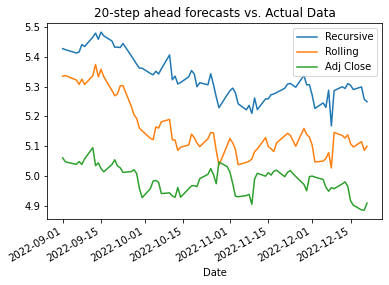


 forecasts 
                 Fixed  Recursive   Rolling  Adj Close
Date                                                 
2022-09-01   5.267143   5.427149  5.334391   5.060684
2022-09-02   5.425099   5.423752  5.336878   5.046980
2022-09-06   5.581538   5.412499  5.321685   5.038731
2022-09-07   5.741187   5.415809  5.307151   5.047942
2022-09-08   5.926391   5.440845  5.324565   5.038278
...               ...        ...       ...        ...
2022-12-15  16.794142   5.304060  5.108186   4.916325
2022-12-16  16.966376   5.289799  5.096986   4.901639
2022-12-19  17.129496   5.298743  5.114902   4.885601
2022-12-20  17.266924   5.256947  5.085874   4.885072
2022-12-21  17.440824   5.248895  5.098976   4.908603

[78 rows x 4 columns]

 MAE 
 Recursive    2.664702
Rolling      1.330276
dtype: float64

 RMSE 
 Recursive    0.970042
Rolling      0.516794
dtype: float64


In [14]:
#=================== Plot forecasts and compute errors ===========================================================================    

# Plot the forecast overview of recursive and rolling windows against actual data  
forecast_overview.iloc[:,1:].plot()
plt.title('20-step ahead forecasts vs. Actual Data')
plt.show()


# Compute the MAE/RMSE and analyze full forecast table --> Select modeln with lowest RMSE
epsilon = forecast_overview.iloc[:,1:3].sub(obs.squeeze(), axis=0)
mae = epsilon.abs().sum(axis=0)/10
rmse = ((epsilon**2).sum(axis=0)/10)**.5
    
print('\n forecasts \n', forecast_overview)
print('\n MAE \n', mae) 
print('\n RMSE \n', rmse) 

<div style="text-align: justify">According to the forecast visual representation and RMSE, we infer that the <strong>rolling window is the most accurate</strong> way to forecast data. In fact, the rolling window based forecast has RMSE nearly twice lower than the one for recursive window based forecasts.</div>
<div style="text-align: justify">In addition, the ouputs are relevant since higher RMSE are noticed for the 20-step ahead forecast. This illustrate the decreasing function of forecasting accuracy with respect to time. </div> 

## Step 4: VaR computations:

Looking at 1173 observations of the df_train dataset:

Number of exceptions of VaR 90% : 246
Number of exceptions of VaR 95% : 169
Number of exceptions of VaR 99% : 74


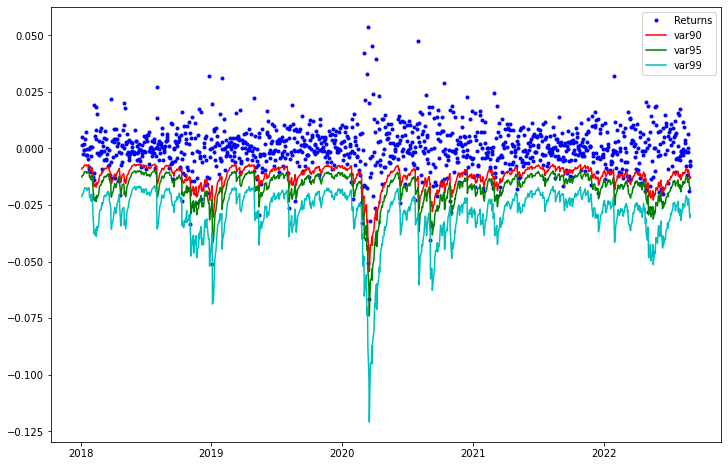

In [43]:
#================== In-sample Value-at-Risk estimates=================

var90 = np.mean(df_train)/100 + res.conditional_volatility * t.ppf(0.10,res.params[4])/100
var95 = np.mean(df_train)/100 + res.conditional_volatility * t.ppf(0.05,res.params[4])/100
var99 = np.mean(df_train)/100 + res.conditional_volatility * t.ppf(0.01,res.params[4])/100

fig = plt.figure(figsize=(12,8))
plt.plot(df_train_std/100, 'b.', label = 'Returns')
plt.plot(var90, 'r-', label = 'var90')
plt.plot(var95, 'g-', label = 'var95')
plt.plot(var99, 'c-', label = 'var99')
plt.legend()
print(f"Looking at {len(df_train)} observations of the df_train dataset:\n")
print(f"Number of exceptions of VaR 90% : {np.sum(df_train/100 < var90)}")
print(f"Number of exceptions of VaR 95% : {np.sum(df_train/100 < var95)}")
print(f"Number of exceptions of VaR 99% : {np.sum(df_train/100 < var99)}")

Looking at 20 observations:

Number of exceptions of VaR 90% : 6
Number of exceptions of VaR 95% : 4
Number of exceptions of VaR 99% : 2


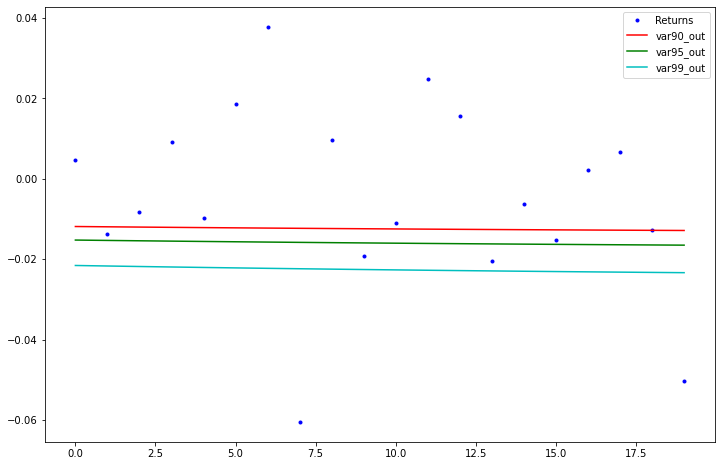

In [44]:
#============= Out-of-sample Value-at-Risk estimates ===========================

# Compute the VaR for the 20-step ahead forecast
var90_out = np.sqrt(res.forecast(horizon=20,reindex=False).variance.iloc[0].values) * norm.ppf(0.1)/100
var95_out = np.sqrt(res.forecast(horizon=20,reindex=False).variance.iloc[0].values) * norm.ppf(0.05)/100
var99_out = np.sqrt(res.forecast(horizon=20,reindex=False).variance.iloc[0].values) * norm.ppf(0.01)/100

fig = plt.figure(figsize=(12,8))
plt.plot(df_test[:20].values/100, 'b.', label = 'Returns')
plt.plot(var90_out, 'r-', label = 'var90_out')
plt.plot(var95_out, 'g-', label = 'var95_out')
plt.plot(var99_out, 'c-', label = 'var99_out')
plt.legend()
print(f"Looking at 20 observations:\n")
print(f"Number of exceptions of VaR 90% : {np.sum(df_test[:20]/100 < var90_out)}")
print(f"Number of exceptions of VaR 95% : {np.sum(df_test[:20]/100 < var95_out)}")
print(f"Number of exceptions of VaR 99% : {np.sum(df_test[:20]/100 < var99_out)}")
